In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, LeakyReLU, Conv2DTranspose
import numpy as np
import time
import json

from IPython import display

In [2]:
BATCH_SIZE = 32
MAP_SIZE = 32
LR_D = LR_G = 0.00005
img_cols, img_rows, channels = 32,32,2
optimizer = tf.optimizers.Adam(0.0002, 0.5)
noise_dim = 128

In [4]:
N = 32

def generate_rect(x, y, w, h):
  data = np.zeros((N,N))
  data[x:x+w+1, y:y+h+1] = 1
  data[x+1:x+w, y+1:y+h] = 0
  #data = np.reshape(data, (N*N))
  return data

train_images = []

for x in range(0, N-2):
  for y in range(0, N-2):
    for w in range(2,N):
      for h in range(2,N):
        if x+w<N and y+h<N:
          train_images.append(generate_rect(x,y,w,h))
train_images = np.array(train_images).astype('int32')
# train_images = train_images[np.random.choice(np.shape(train_images)[0], 1000, replace=False)]

print(np.shape(train_images))

(216225, 32, 32)


In [9]:
train_images = train_images[np.random.choice(np.shape(train_images)[0], 1000, replace=False)]
print(np.shape(train_images))

(1000, 32, 32)


In [ ]:
plt.imshow(train_images[2])


In [10]:
train_size, x_dims, y_dims = train_images.shape
z_dims = np.amax(train_images) + 1 # Number of different title types
print(z_dims)
train_images_onehot = np.eye(z_dims, dtype='uint8')[train_images]
print(train_images_onehot.shape) # (train_size, x_dims, y_dims, z_dims)

train_images = np.zeros((train_size, MAP_SIZE, MAP_SIZE, z_dims))
print(train_images.shape)

# TODO: Change empty space encoding here if different
train_images[:, :, :, 1] = 0.0  # Fill with empty space 

train_images[:train_size, :x_dims, :y_dims, :] = train_images_onehot
print(train_images.shape)

2
(1000, 32, 32, 2)
(1000, 32, 32, 2)
(1000, 32, 32, 2)


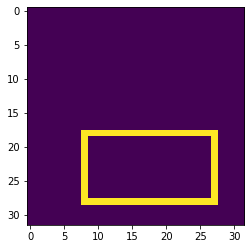

In [6]:
plt.imshow(np.argmax(train_images[2], axis=2))

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(BATCH_SIZE)

In [5]:
def make_discriminator_model(n_extra_layers=0):
  discriminator = Sequential()
    
  discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Flatten())
  discriminator.add(Dropout(0.4))
  discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
  
  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
  return discriminator

In [6]:
def make_generator_model(n_extra_layers=0):
  generator = Sequential()
    
  # Starting size
  d = 4
  generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
  generator.add(LeakyReLU(0.2))
  # 4x4x256
  generator.add(Reshape((d, d, 256)))
  
  # 8x8x128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  
  # 16x16*128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  
  # 32x32x128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  
  # 32x32x3
  generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
  
  generator.compile(loss='binary_crossentropy', optimizer=optimizer)
  return generator

In [7]:
steps_per_epoch = 3750
epochs = 10
noise_dim = 128

from keras.layers import Input
from keras.models import Model

gan_input = Input(shape=(noise_dim,))

In [12]:
"""import os
TPU_WORKER = "grpc://" + os.environ["COLAB_TPU_ADDR"]
tf.config.experimental_connect_to_host(TPU_WORKER)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_WORKER)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)"""

'import os\nTPU_WORKER = "grpc://" + os.environ["COLAB_TPU_ADDR"]\ntf.config.experimental_connect_to_host(TPU_WORKER)\n\nresolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_WORKER)\ntf.tpu.experimental.initialize_tpu_system(resolver)\nstrategy = tf.distribute.TPUStrategy(resolver)'

In [13]:
"""with strategy.scope():
    discriminator = make_discriminator_model()
    generator = make_generator_model()

    fake_image = generator(gan_input)
    gan_output = discriminator(fake_image)

    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer) """
    
    

"with strategy.scope():\n    discriminator = make_discriminator_model()\n    generator = make_generator_model()\n\n    fake_image = generator(gan_input)\n    gan_output = discriminator(fake_image)\n\n    gan = Model(gan_input, gan_output)\n    gan.compile(loss='binary_crossentropy', optimizer=optimizer) "

In [14]:
discriminator = make_discriminator_model()
generator = make_generator_model()

fake_image = generator(gan_input)
gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer) 

In [15]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
        fake_x = generator.predict(noise, verbose = 0)
        fake_x = np.reshape(fake_x, (fake_x.shape[0],(32*32*2)))
        real_x = train_images[np.random.randint(0, train_images.shape[0], size=BATCH_SIZE)]
        real_x = np.reshape(real_x, (real_x.shape[0],(32*32*2)))
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        #disc_y = np.ones(BATCH_SIZE)

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')

KeyboardInterrupt: 

In [23]:
def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if 2 == 1:
            plt.imshow(image.reshape((32, 32)), cmap='gray')
        else:
            plt.imshow(np.argmax(image.reshape(32, 32, 2), axis=2))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

4/4 [==============================] - 0s 3ms/step


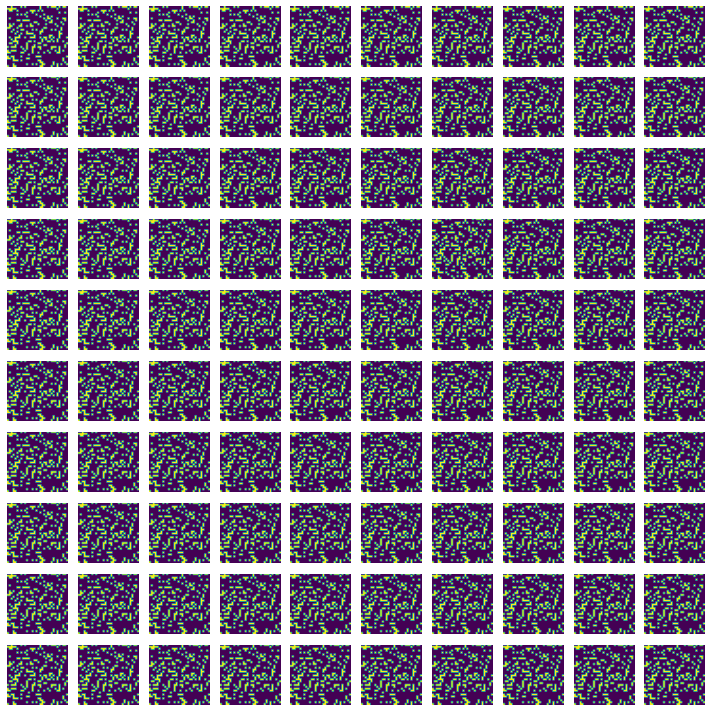

In [24]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)